In [94]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
navoneel_brain_mri_images_for_brain_tumor_detection_path = kagglehub.dataset_download('navoneel/brain-mri-images-for-brain-tumor-detection')
print('Data source import complete.')


Data source import complete.


## **Import needed Libraries**

In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import warnings

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from PIL import Image
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam ,Adamax
from tensorflow.keras.layers import  Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Flatten ,Input ,GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

## **Read data**

In [96]:
data_path  = "/kaggle/input/brain-mri-images-for-brain-tumor-detection"
images = []
Labels = []
folder_name = os.listdir(data_path)
for name_class in folder_name:
   class_path = os.path.join(data_path , name_class)
   image_path = os.listdir(class_path)
   for img_path in image_path:
    full_image_path = os.path.join(class_path ,img_path)
    images.append(full_image_path)
    Labels.append(name_class)

image_series  = pd.Series(images , name ="Image_Path")
label_series = pd.Series(Labels , name = "Labels")
data = pd.concat([image_series , label_series] , axis=1)

In [97]:
data

Image_Path               Labels
0    /kaggle/input/brain-mri-images-for-brain-tumor...                   no
1    /kaggle/input/brain-mri-images-for-brain-tumor...                   no
2    /kaggle/input/brain-mri-images-for-brain-tumor...                   no
3    /kaggle/input/brain-mri-images-for-brain-tumor...                   no
4    /kaggle/input/brain-mri-images-for-brain-tumor...                   no
..                                                 ...                  ...
250  /kaggle/input/brain-mri-images-for-brain-tumor...                  yes
251  /kaggle/input/brain-mri-images-for-brain-tumor...                  yes
252  /kaggle/input/brain-mri-images-for-brain-tumor...                  yes
253  /kaggle/input/brain-mri-images-for-brain-tumor...  brain_tumor_dataset
254  /kaggle/input/brain-mri-images-for-brain-tumor...  brain_tumor_dataset

[255 rows x 2 columns]

In [98]:
data.shape

(255, 2)

## **Split data**

In [99]:
start = data["Labels"]
data_Train , data_test = train_test_split(data , train_size=0.8 , random_state=42 , shuffle=True , stratify=start )

In [100]:
data_Train.shape

(204, 2)

In [101]:
data_test.shape

(51, 2)

## **Create image data generator**

In [156]:
batch_size = 32
image_size = (224, 224)


train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_gen.flow_from_dataframe(
    data_Train,
    x_col="Image_Path",
    y_col="Labels",
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    color_mode="rgb",
    shuffle=True
)

test_generator = test_gen.flow_from_dataframe(
    data_test,
    x_col="Image_Path",
    y_col="Labels",
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    color_mode="rgb",
    shuffle=False
)

Found 202 validated image filenames belonging to 2 classes.
Found 51 validated image filenames belonging to 2 classes.


## **Show sample from train data**

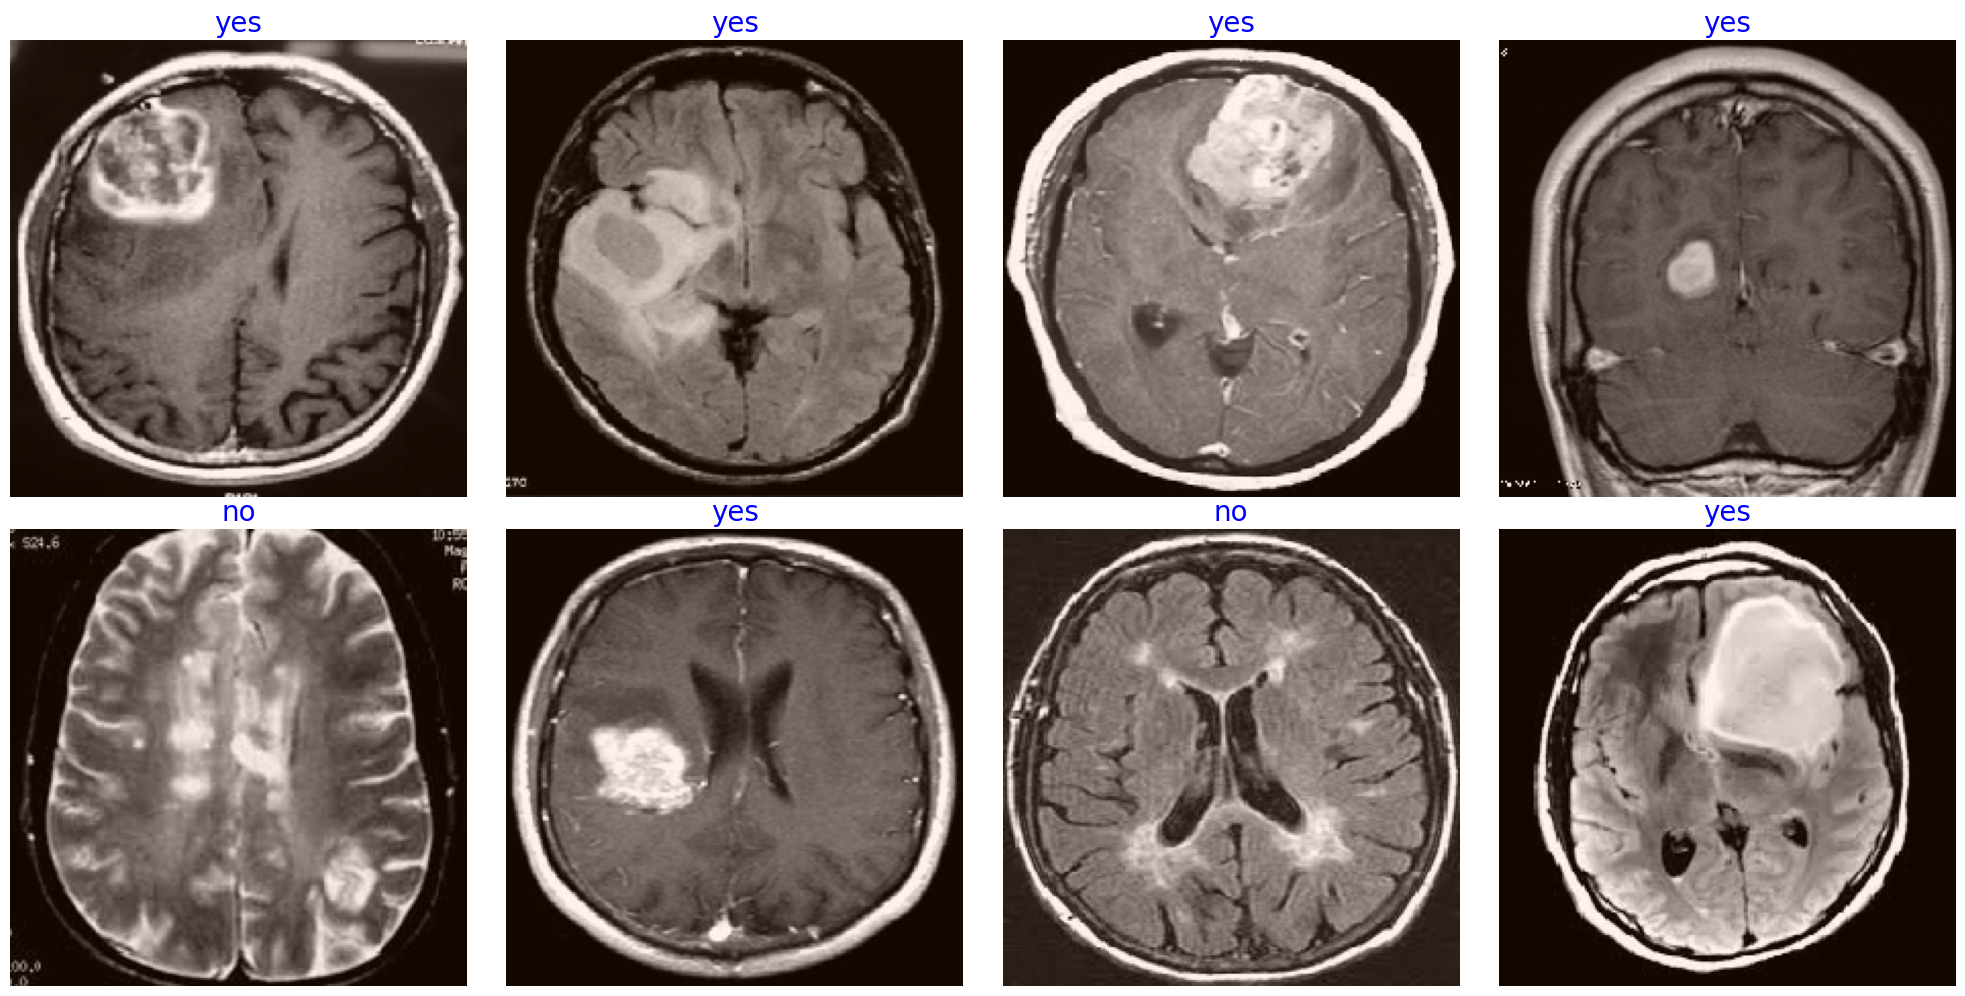

In [157]:
data_train_dict = train_generator.class_indices
Class_Name_train = list(data_train_dict.keys())

image_train, label_train = next(train_generator)

plt.figure(figsize=(20, 10))
for i in range(8):
    img_train = image_train[i]
    img_train = (img_train - img_train.min()) / (img_train.max() - img_train.min())

    plt.subplot(2, 4, i+1)
    plt.imshow(img_train)

    indx = np.argmax(label_train[i])
    Classes_name = Class_Name_train[indx]
    plt.title(Classes_name, color="blue", fontsize=20)
    plt.axis("off")

plt.tight_layout()
plt.show()


## **Show sample from test data**

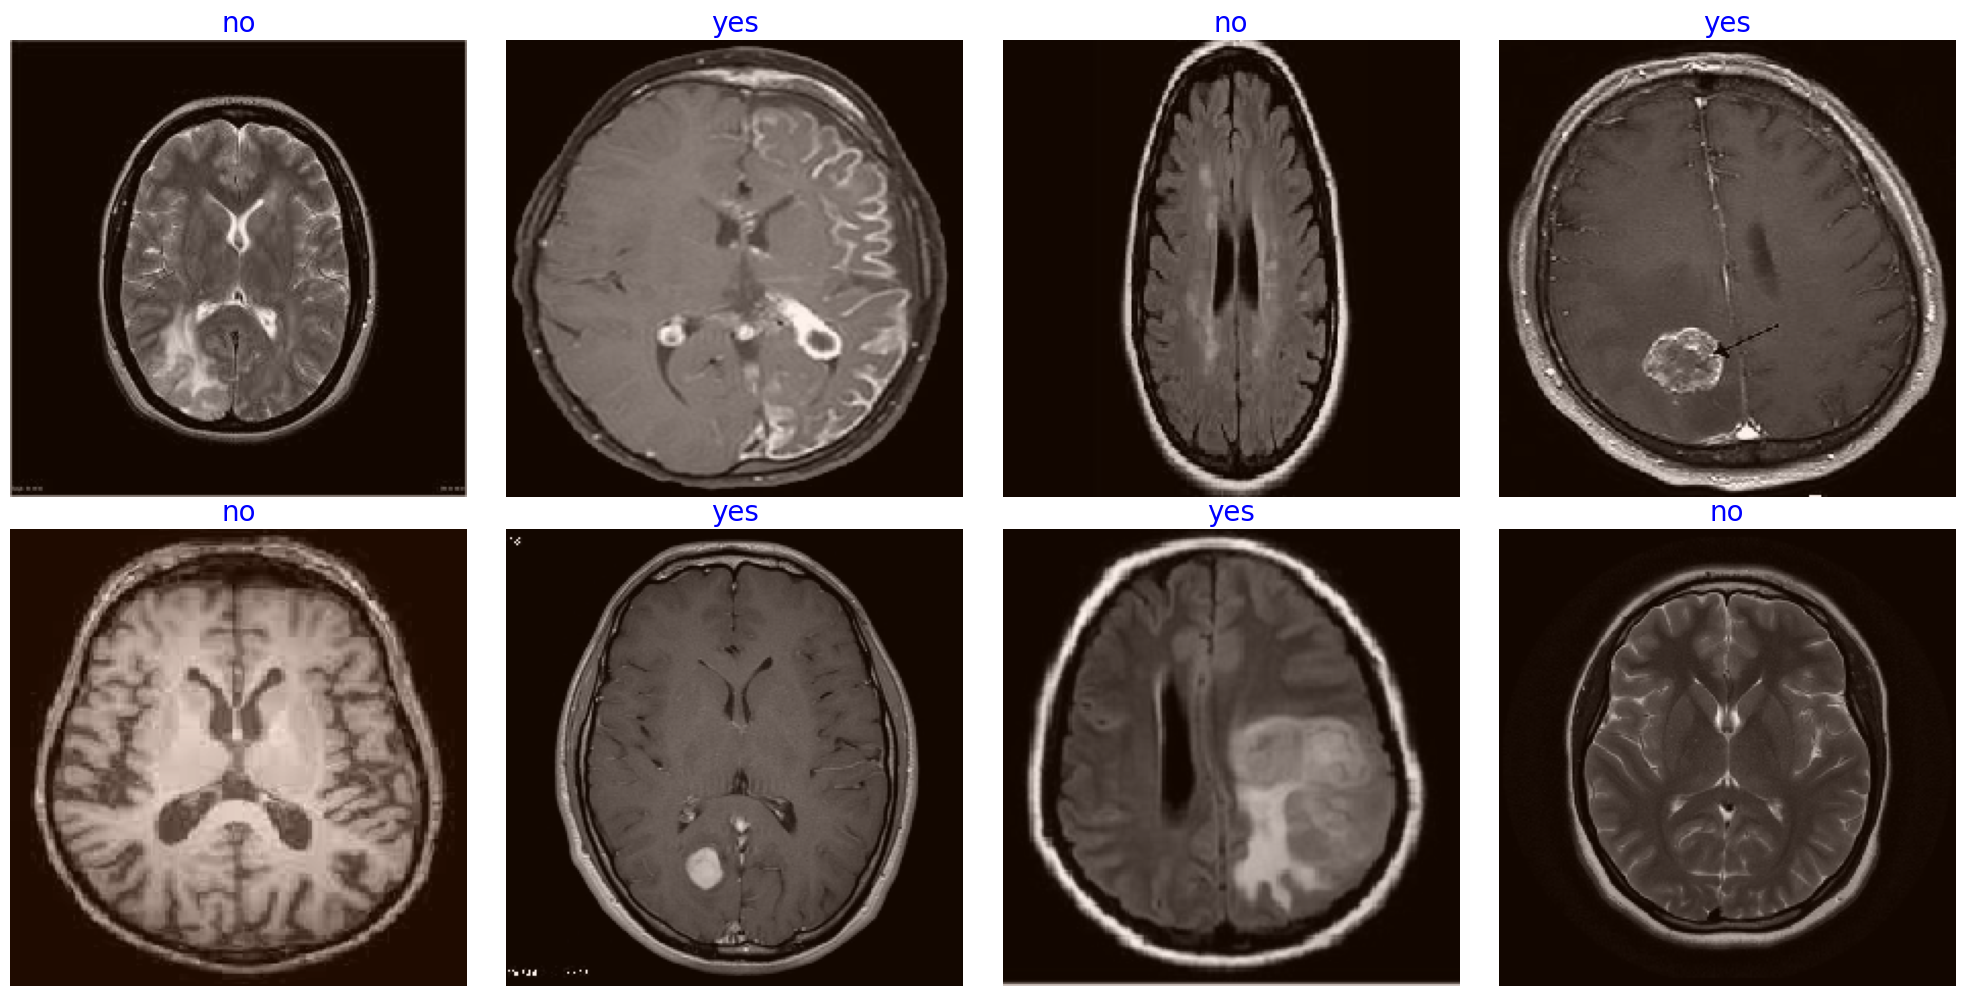

In [155]:
data_test_dict = test_generator.class_indices
class_name_test = list(data_test_dict.keys())

image_test, label_test = next(test_generator)

plt.figure(figsize=(20, 10))
for i in range(8):
    img_test = image_test[i]
    img_test = (img_test - img_test.min()) / (img_test.max() - img_test.min())
    plt.subplot(2, 4, i+1)
    plt.imshow(img_test.squeeze(), cmap="gray")
    index = np.argmax(label_test[i])
    Classes_name = class_name_test[index]
    plt.title(Classes_name, color="blue", fontsize=20)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [119]:
count_class = len(list(data_test_dict.keys()))
count_class

2

## **Model Structure**

In [128]:
input_layer = Input(shape=(224, 224, 3))


base_resnet = tf.keras.applications.ResNet50(include_top=False, weights='imagenet',input_tensor=input_layer)
base_resnet.trainable = False

model_resnet = Sequential([
   base_resnet,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='sigmoid')
])

model_resnet.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model_resnet.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,137,026 (92.08 MB)

 Trainable params: 545,218 (2.08 MB)

 Non-trainable params: 23,591,808 (90.00 MB)

In [127]:
callbacks = [
    EarlyStopping(monitor='val_loss',patience=5, restore_best_weights=True),
]

In [129]:
epochs = 30
history = model_resnet.fit(train_generator, epochs= epochs,callbacks=callbacks, verbose= 1,validation_data= test_generator)

Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.5222 - loss: 0.9173 - val_accuracy: 0.7843 - val_loss: 0.6273
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step - accuracy: 0.7110 - loss: 0.6829 - val_accuracy: 0.8627 - val_loss: 0.5750
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - accuracy: 0.7749 - loss: 0.6360 - val_accuracy: 0.8627 - val_loss: 0.5371
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - accuracy: 0.7796 - loss: 0.5978 - val_accuracy: 0.8431 - val_loss: 0.5085
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step - accuracy: 0.8240 - loss: 0.5611 - val_accuracy: 0.8431 - val_loss: 0.4874
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 189ms/step - accuracy: 0.8212 - loss: 0.4617 - val_accuracy: 0.8431 - val_loss: 0.4707
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - accuracy: 0.8895 - loss: 0.3669 - val_accuracy: 0.8431 - val_loss: 0.4568
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - accuracy: 0.8923 - loss: 0.3601 - val_accuracy: 0.8431 - val_loss: 0

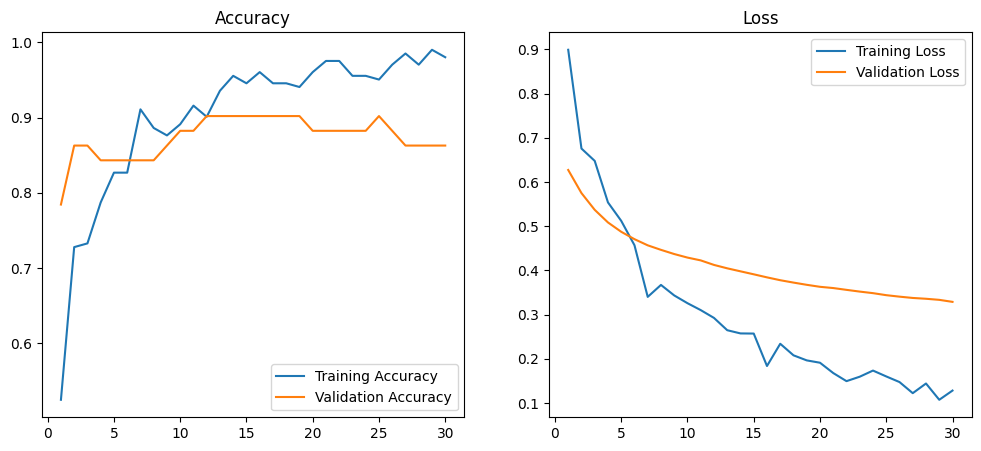

In [130]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()


In [131]:
model_resnet.evaluate(train_generator, verbose= 1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 497ms/step - accuracy: 0.9865 - loss: 0.1094


[0.09903185069561005, 0.9900990128517151]

In [133]:
model_resnet.evaluate(test_generator, verbose= 1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.8668 - loss: 0.3228


[0.3288198709487915, 0.8627451062202454]

In [134]:
y_pred = model_resnet.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step


In [135]:
y_pred

array([0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1])

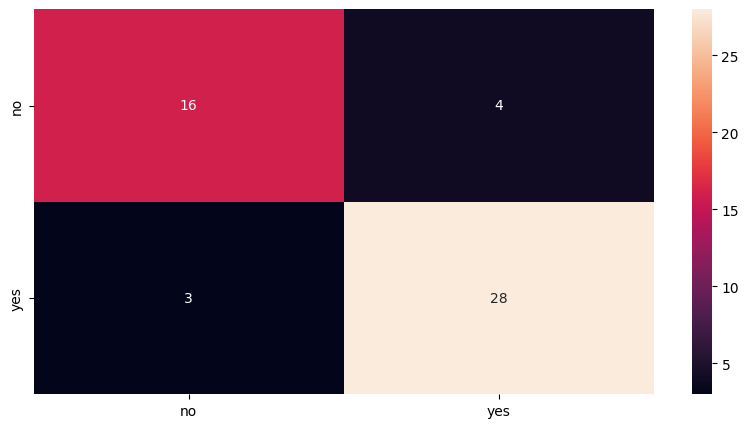

In [140]:
conff= confusion_matrix(test_generator.classes , y_pred)
plt.figure(figsize=(10,5))
sns.heatmap(conff , annot= True ,fmt="d" , xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.show()

In [142]:
def miss_classified(matrix):
    counter=0
    for i  in range(len(conf)):
        for j  in range(len(conff)):
            if i==j:
                continue
            else:
                counter+=conff[i][j]
    return f"Miss-classified samples of this model: {counter}"
miss_classified(conff)

'Miss-classified samples of this model: 7'

In [143]:
print(classification_report (test_generator.classes , y_pred))

              precision    recall  f1-score   support

           0       0.84      0.80      0.82        20
           1       0.88      0.90      0.89        31

    accuracy                           0.86        51
   macro avg       0.86      0.85      0.85        51
weighted avg       0.86      0.86      0.86        51



In [144]:
model_resnet.save('Brain Tumors in CNN_whit_Pre-Trained_model_use_resnet.h5')

In [148]:
loaded_model = tf.keras.models.load_model('/content/Brain Tumors in CNN_whit_Pre-Trained_model_use_resnet.h5', compile=False)
loaded_model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])



# Image path
image_path = '/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes/Y10.jpg'
image = Image.open(image_path).convert("RGB")

# Preprocess the image before prediction
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = ['NO', 'YES']

# Print the predicted class
predicted_class = class_labels[np.argmax(predictions)]
print(predicted_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
YES


In [149]:
loaded_model = tf.keras.models.load_model('/content/Brain Tumors in CNN_whit_Pre-Trained_model_use_resnet.h5', compile=False)
loaded_model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])



# Image path
image_path = '/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/10 no.jpg'
image = Image.open(image_path).convert("RGB")

# Preprocess the image before prediction
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = ['NO', 'YES']

# Print the predicted class
predicted_class = class_labels[np.argmax(predictions)]
print(predicted_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
NO
